In [19]:
import matplotlib.pyplot as plt
import numpy
%matplotlib inline

In [4]:
xs = numpy.arange(-5,5, 0.25)


In [5]:
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [21]:
def f(x):
    return (3*x**2) - 4*x + 2

In [22]:
ys = f(xs)

In [23]:
ys

array([97.    , 88.6875, 80.75  , 73.1875, 66.    , 59.1875, 52.75  ,
       46.6875, 41.    , 35.6875, 30.75  , 26.1875, 22.    , 18.1875,
       14.75  , 11.6875,  9.    ,  6.6875,  4.75  ,  3.1875,  2.    ,
        1.1875,  0.75  ,  0.6875,  1.    ,  1.6875,  2.75  ,  4.1875,
        6.    ,  8.1875, 10.75  , 13.6875, 17.    , 20.6875, 24.75  ,
       29.1875, 34.    , 39.1875, 44.75  , 50.6875])

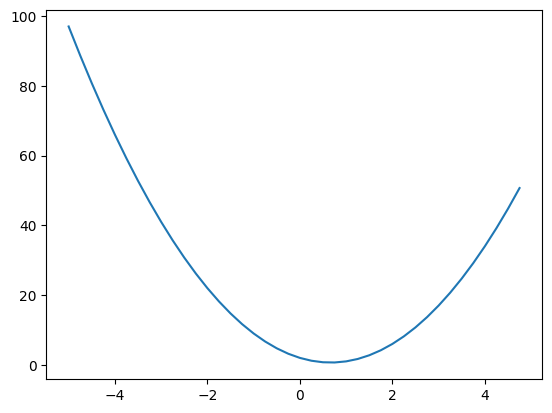

In [24]:
plt.plot(xs,ys)

In [79]:
class Value():
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.grad = 0
        self.label = label

    def __repr__(self):
        return f"Value (data={self.data})"

    
    def __add__(self,  other):
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self,  other):
        return Value(self.data * other.data, (self, other), '*')
    

In [73]:
from graphviz import Digraph

In [106]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label,n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

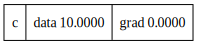

In [107]:
draw_dot(c)

0.0


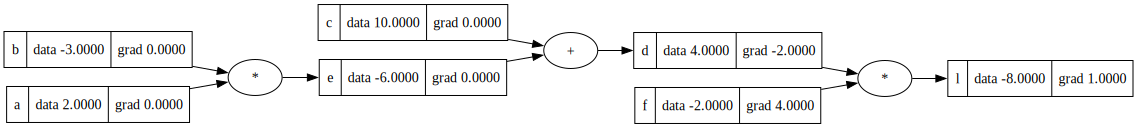

In [125]:
# def lol():
h = 0.00001
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e+c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label = "l"
L1 = L.data


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
h = Value(h)
d = e +c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label = "l"
L2 = L.data 

f.grad = 4
d.grad = -2
L.grad = 1
print((L2 - L1) /h.data)
draw_dot(L)

In [122]:
lol()

0.0


In [84]:
L.grad = 1

NameError: name 'L' is not defined

NameError: name 'L' is not defined

In [4]:
class MinStack:

    def __init__(self):
        self.stack = []

    def push(self, val: int) -> None:
        self.stack.append(val)

    def pop(self) -> None:
        end = len(self.stack) -1
        value = self.stack[end]
        del self.stack[end]
        return value

    def top(self) -> int:
        end = len(self.stack) -1
        value = self.stack[end]
        return value

    def getMin(self) -> int:
        return min(self.stack)

        # min = int(float('inf'))
        # min = 
        # for val in self.stack:
        #     if val < min:
        #         min


In [8]:
stack = MinStack()
stack.push(5)
stack.push(2)
stack.push(1)


In [13]:
stack.top()

2

In [2]:
a = [1,2,3]
min(a)

1